In [1]:
from ast import literal_eval

import pandas as pd

In [2]:
links = pd.read_csv('data/raw/links.csv', usecols=['movieId','tmdbId'])
links.rename(columns={'movieId':'id','tmdbId':'tmdb_id'}, inplace=True)
links['tmdb_id'] = links['tmdb_id'].astype('Int64')
links.set_index('tmdb_id', inplace=True)
links.head()

,id
tmdb_id,
862,1
8844,2
15602,3
31357,4
11862,5


In [3]:
credits = pd.read_csv('data/raw/credits.csv')
credits.rename(columns={'id':'tmdb_id'}, inplace=True)
credits['tmdb_id'] = credits['tmdb_id'].astype('Int64')
credits.set_index('tmdb_id', inplace=True)
credits = credits.join(links, how='inner').reset_index(drop=True)
credits.head()

,cast,crew,id
0,"[{'cast_id': 3, 'character': 'Taisto Olavi Kas...","[{'credit_id': '52fe420dc3a36847f800001f', 'de...",4470
1,"[{'cast_id': 5, 'character': 'Nikander', 'cred...","[{'credit_id': '52fe420dc3a36847f8000077', 'de...",61724
2,"[{'cast_id': 42, 'character': 'Ted the Bellhop...","[{'credit_id': '52fe420dc3a36847f800011b', 'de...",18
3,"[{'cast_id': 7, 'character': 'Frank Wyatt', 'c...","[{'credit_id': '52fe420dc3a36847f800023d', 'de...",479
4,"[{'cast_id': 3, 'character': 'Luke Skywalker',...","[{'credit_id': '52fe420dc3a36847f8000437', 'de...",260


In [4]:
pd.DataFrame.from_dict(literal_eval(credits.cast[0]))

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,3,Taisto Olavi Kasurinen,52fe420dc3a36847f8000029,0,54768,Turo Pajala,0,None
1,4,Irmeli Katariina Pihlaja,52fe420dc3a36847f800002d,0,54769,Susanna Haavisto,1,None
2,5,Mikkonen,52fe420dc3a36847f8000031,2,4826,Matti Pellonpää,2,/7WuLvkuWphUAtW6QQwtF3WrwUKE.jpg
3,6,Riku,52fe420dc3a36847f8000035,0,54770,Eetu Hilkamo,3,None


In [5]:
%%time

cast = []
for i in credits.id:
    df_dict = literal_eval(credits.loc[credits['id'] == i].cast.values[0])
    if len(df_dict) > 0:
        df = pd.DataFrame.from_dict(df_dict)[['id','name']]
        df.columns = ['actor_id','actor_name']
        df['id'] = i
        cast.append(df)

cast = pd.concat(cast, ignore_index=True)
cast.head()

CPU times: user 2min 37s, sys: 560 ms, total: 2min 38s
Wall time: 2min 38s


,actor_id,actor_name,id
0,54768,Turo Pajala,4470
1,54769,Susanna Haavisto,4470
2,4826,Matti Pellonpää,4470
3,54770,Eetu Hilkamo,4470
4,4826,Matti Pellonpää,61724


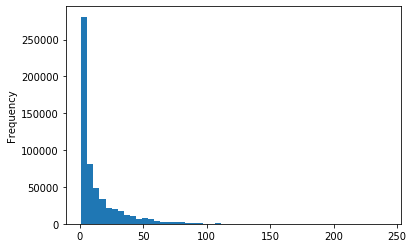

In [6]:
cast['num_movies'] = cast.groupby('actor_id')['actor_id'].transform('count')
cast['num_movies'].plot.hist(bins=50)

In [7]:
cast.loc[cast.num_movies >= 10].to_csv('data/movie_actor.csv', index=False)

In [8]:
pd.DataFrame.from_dict(literal_eval(credits.crew[0]))

,credit_id,department,gender,id,job,name,profile_path
0,52fe420dc3a36847f800001f,Writing,0,16767,Screenplay,Aki Kaurismäki,/8nQcTzKUmRh6MPprd1n6iOauYPf.jpg
1,52fe420dc3a36847f8000025,Directing,0,16767,Director,Aki Kaurismäki,/8nQcTzKUmRh6MPprd1n6iOauYPf.jpg
2,52fe420dc3a36847f800003b,Camera,2,16769,Director of Photography,Timo Salminen,None
3,52fe420dc3a36847f8000041,Editing,0,54766,Editor,Raija Talvio,None
4,52fe420dc3a36847f8000047,Art,2,53836,Production Design,Risto Karhula,None
5,52fe420dc3a36847f800004d,Costume & Make-Up,0,54771,Costume Design,Tuula Hilkamo,None


In [9]:
%%time

crew = []
for i in credits.id:
    df_dict = literal_eval(credits.loc[credits['id'] == i].crew.values[0])
    if len(df_dict) > 0:
        df = pd.DataFrame.from_dict(df_dict)[['id','job','name']]
        df.columns = ['person_id','job','person_name']
        df['id'] = i
        crew.append(df)

crew = pd.concat(crew, ignore_index=True)
crew.head()

CPU times: user 2min 34s, sys: 200 ms, total: 2min 34s
Wall time: 2min 34s


,person_id,job,person_name,id
0,16767,Screenplay,Aki Kaurismäki,4470
1,16767,Director,Aki Kaurismäki,4470
2,16769,Director of Photography,Timo Salminen,4470
3,54766,Editor,Raija Talvio,4470
4,53836,Production Design,Risto Karhula,4470


In [10]:
crew['job'].value_counts()

Director                    49108
Producer                    43630
Writer                      30483
Screenplay                  25187
Editor                      23854
                            ...  
Opening/Ending Animation        1
Lead Character Designer         1
Dramaturgie                     1
3D Director                     1
Cloth Setup                     1
Name: job, Length: 456, dtype: int64

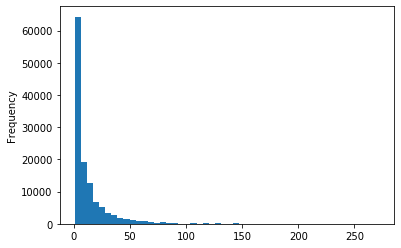

In [11]:
crew['num_movies'] = crew.groupby('person_id')['person_id'].transform('count')
jobs = ['director','producer','writer']
crew.loc[crew['job'].str.lower().isin(jobs), 'num_movies'].plot.hist(bins=50)

In [12]:
crew.loc[crew['job'].str.lower().isin(jobs) & (crew['num_movies'] >= 10)].to_csv('data/movie_producer.csv', index=False)

In [13]:
movies = pd.read_csv('data/raw/movies_metadata.csv', usecols=['id','original_title','title','overview','tagline','genres'])
movies.rename(columns={'id':'tmdb_id'}, inplace=True)
movies['tmdb_id'] = pd.to_numeric(movies['tmdb_id'], errors='coerce')
movies.dropna(inplace=True)
movies.set_index('tmdb_id', inplace=True)
movies = movies.join(links, how='inner').reset_index(drop=True)
movies.head()

,genres,original_title,overview,tagline,title,id
0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",Four Rooms,It's Ted the Bellhop's first night on the job....,Twelve outrageous guests. Four scandalous requ...,Four Rooms,18
1,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",Judgment Night,"While racing to a boxing match, Frank, Mike, J...",Don't move. Don't whisper. Don't even breathe.,Judgment Night,479
2,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",Star Wars,Princess Leia is captured and held hostage by ...,"A long time ago in a galaxy far, far away...",Star Wars,260
3,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",There are 3.7 trillion fish in the ocean. They...,Finding Nemo,6377
4,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Forrest Gump,A man with a low IQ has accomplished great thi...,"The world will never be the same, once you've ...",Forrest Gump,356


In [14]:
movies[['id','original_title','title','overview','tagline']].to_csv('data/movie_info.csv', index=False)

In [15]:
pd.DataFrame.from_dict(literal_eval(movies.genres[0]))

,id,name
0,80,Crime
1,35,Comedy


In [16]:
%%time

genre = []
for i in movies.id:
    df_dict = literal_eval(movies.loc[movies['id'] == i].genres.values[0])
    if len(df_dict) > 0:
        df = pd.DataFrame.from_dict(df_dict)[['id','name']]
        df.columns = ['genre_id','genre_name']
        df['id'] = i
        genre.append(df)

genre = pd.concat(genre, ignore_index=True)
genre.head()

CPU times: user 54.3 s, sys: 152 ms, total: 54.4 s
Wall time: 54.3 s


,genre_id,genre_name,id
0,80,Crime,18
1,35,Comedy,18
2,28,Action,479
3,53,Thriller,479
4,80,Crime,479


In [17]:
genre.to_csv('data/movie_genre.csv', index=False)

In [18]:
keywords = pd.read_csv('data/raw/keywords.csv')
keywords.rename(columns={'id':'tmdb_id'}, inplace=True)
keywords['tmdb_id'] = keywords['tmdb_id'].astype('Int64')
keywords.set_index('tmdb_id', inplace=True)
keywords = keywords.join(links, how='inner').reset_index(drop=True)
keywords.head()

,keywords,id
0,"[{'id': 240, 'name': 'underdog'}, {'id': 378, ...",4470
1,"[{'id': 1361, 'name': 'salesclerk'}, {'id': 17...",61724
2,"[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...",18
3,"[{'id': 520, 'name': 'chicago'}, {'id': 2231, ...",479
4,"[{'id': 803, 'name': 'android'}, {'id': 4270, ...",260


In [19]:
pd.DataFrame.from_dict(literal_eval(keywords.keywords[0]))

,id,name
0,240,underdog
1,378,prison
2,730,factory worker
3,1563,prisoner
4,1787,helsinki
5,10183,independent film
6,13072,falling in love


In [20]:
' '.join([i['name'] for i in literal_eval(keywords.keywords[0])])

'underdog prison factory worker prisoner helsinki independent film falling in love'

In [21]:
%%time

keys = []
for i in keywords.id:
    df_dict = literal_eval(keywords.loc[keywords['id'] == i].keywords.values[0])
    if len(df_dict) > 0:
        kw = ' '.join([i['name'] for i in df_dict])
        df = pd.DataFrame(data={'keywords': [kw]})
        df['id'] = i
        keys.append(df)

keys = pd.concat(keys, ignore_index=True)
keys.head()

CPU times: user 1min, sys: 176 ms, total: 1min
Wall time: 1min


,keywords,id
0,underdog prison factory worker prisoner helsin...,4470
1,salesclerk helsinki garbage independent film,61724
2,hotel new year's eve witch bet hotel room sper...,18
3,chicago drug dealer boxing match escape one night,479
4,android galaxy hermit death star lightsaber je...,260


In [22]:
keys.to_csv('data/movie_keywords.csv', index=False)

In [23]:
tags = pd.read_csv('data/raw/tags.csv', usecols=['movieId','tag'])
tags.head()

,movieId,tag
0,110,epic
1,110,Medieval
2,260,sci-fi
3,260,space action
4,318,imdb top 250


In [24]:
%%time

tags_groups = tags[['movieId','tag']].dropna().groupby('movieId', sort=False)
tags = tags_groups['tag'].agg(tags=lambda x: ' '.join(x)).reset_index(drop=False)
tags.columns = ['id', 'tags']
tags.head()

CPU times: user 952 ms, sys: 32 ms, total: 984 ms
Wall time: 982 ms


,id,tags
0,110,epic Medieval overrated Oscar (Best Picture) e...
1,260,sci-fi space action classic sci-fi Harrison Fo...
2,318,imdb top 250 justice story line hope inspirati...
3,480,Dinosaurs dinosaurs action thriller dinosaurs ...
4,593,psychothriller brilliant exploratory ligne de ...


In [25]:
tags.to_csv('data/movie_tags.csv', index=False)

In [26]:
ratings = pd.read_csv('data/raw/ratings.csv', usecols=['userId','movieId','rating'])
ratings.columns = ['user','id','rating']
ratings.head()

,user,id,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [27]:
ratings['user_votes'] = ratings.groupby('user')['user'].transform('count')
ratings['movie_votes'] = ratings.groupby('id')['id'].transform('count')

In [28]:
ratings.loc[(ratings['movie_votes'] >= 1000) & (ratings['user_votes'] >= 5), ['user','id','rating']].to_csv('data/movie_ratings.csv', index=False)